In [ ]:
!pip install transformers==4.5.0

In [13]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from transformers import get_linear_schedule_with_warmup

In [14]:
epochs = 50
batch_size = 32

myseed = 1
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

In [15]:
train_dataset = torchvision.datasets.FashionMNIST('/content', train=True, download=True, transform=torchvision.transforms.ToTensor())
test_dataset_class_8 = torchvision.datasets.FashionMNIST('/content', train=False, download=True, transform=torchvision.transforms.ToTensor())
test_dataset_no_class_8 = torchvision.datasets.FashionMNIST('/content', train=False, download=True, transform=torchvision.transforms.ToTensor())

#分類條件
train_no_class_8 = (train_dataset.targets != 8)
test_class_8 = (test_dataset_class_8.targets == 8)
test_no_class_8 = (test_dataset_no_class_8.targets != 8)

#訓練集捨棄第8類-Bag
train_dataset.targets = train_dataset.targets[train_no_class_8]
train_dataset.data = train_dataset.data[train_no_class_8]

#測試集區分成包含第8類和不包含第8類的dataset
test_dataset_class_8.targets = test_dataset_class_8.targets[test_class_8]
test_dataset_class_8.data = test_dataset_class_8.data[test_class_8]
test_dataset_no_class_8.targets = test_dataset_no_class_8.targets[test_no_class_8]
test_dataset_no_class_8.data = test_dataset_no_class_8.data[test_no_class_8]

In [16]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=2)
test_class_8_loader = torch.utils.data.DataLoader(test_dataset_class_8, batch_size=16, shuffle=True)
test_no_class_8_loader = torch.utils.data.DataLoader(test_dataset_no_class_8, batch_size=16, shuffle=True)

In [17]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [18]:
example_data.shape

torch.Size([32, 1, 28, 28])

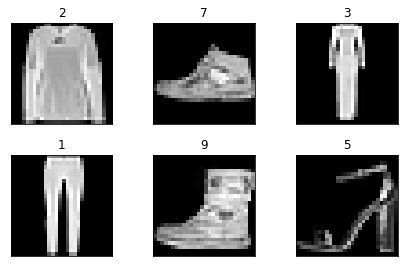

In [19]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray')
  plt.title("{}".format((example_targets[i])))
  plt.xticks([])
  plt.yticks([])

In [20]:
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 512, 4, stride=2, padding=1),  
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 1024, 4, stride=2, padding=1), 
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),   
        )
        self.decoder = nn.Sequential(
            nn.Linear(1024, 1024*7*7),
            nn.Unflatten(1, (1024, 7, 7)),
            nn.ConvTranspose2d(1024, 512, 4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 1, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [21]:
# Warm up
warm_up_ratio = 0.1
step = len(train_loader)
total_step = epochs * step

model = conv_autoencoder().cuda()
optimizer = torch.optim.RAdam(model.parameters(), lr=1e-4, weight_decay=0)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = warm_up_ratio * total_step, num_training_steps = total_step)

In [22]:
best_loss = np.inf

model.train()
for epoch in range(epochs):
    tot_loss = list()
    for data, _ in train_loader:
        # ===================loading=====================
        img = data.cuda()
        # ================A face forward===============
        output = model(img)
        loss = F.mse_loss(output, img)
        tot_loss.append(loss.item())
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()     
    # ===================save_best====================
    mean_loss = np.mean(tot_loss)
    if mean_loss < best_loss:
        best_loss = mean_loss
        torch.save(model, 'best_model.pt')
    # ===================log========================
    print(f"Epoch {epoch + 1:.0f}/{epochs:.0f} | loss = {mean_loss:.7f}")

Epoch 1/50 | loss = 0.4668589
Epoch 2/50 | loss = 0.2932855
Epoch 3/50 | loss = 0.0523349
Epoch 4/50 | loss = 0.0321523
Epoch 5/50 | loss = 0.0282752
Epoch 6/50 | loss = 0.0232418
Epoch 7/50 | loss = 0.0195285
Epoch 8/50 | loss = 0.0172799
Epoch 9/50 | loss = 0.0154188
Epoch 10/50 | loss = 0.0140227
Epoch 11/50 | loss = 0.0128336
Epoch 12/50 | loss = 0.0118974
Epoch 13/50 | loss = 0.0111470
Epoch 14/50 | loss = 0.0103848
Epoch 15/50 | loss = 0.0099098
Epoch 16/50 | loss = 0.0093241
Epoch 17/50 | loss = 0.0089175
Epoch 18/50 | loss = 0.0085179
Epoch 19/50 | loss = 0.0081140
Epoch 20/50 | loss = 0.0078033
Epoch 21/50 | loss = 0.0074681
Epoch 22/50 | loss = 0.0071631
Epoch 23/50 | loss = 0.0069331
Epoch 24/50 | loss = 0.0066848
Epoch 25/50 | loss = 0.0064715
Epoch 26/50 | loss = 0.0062815
Epoch 27/50 | loss = 0.0060881
Epoch 28/50 | loss = 0.0059055
Epoch 29/50 | loss = 0.0057033
Epoch 30/50 | loss = 0.0055649
Epoch 31/50 | loss = 0.0054053
Epoch 32/50 | loss = 0.0052661
Epoch 33/50 | los

In [23]:
# load trained model
checkpoint_path = 'best_model.pt'
model = torch.load(checkpoint_path)
model.eval()

conv_autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): AdaptiveAvgPool2d(output_size=(1, 1))
    (7): Flatten(start_dim=1, end_dim=-1)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1024, out_features=50176, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(1024, 7, 7))
    (2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU()
    (5): ConvTranspose2d(512, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): Tanh()
  )
)

In [24]:
# Show images
def show_images(images): 
    plt.figure().set_size_inches(7,7)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    for index, image in enumerate(images):
        plt.subplot(sqrtn, sqrtn, index+1)
        plt.tight_layout()
        plt.imshow(torchvision.transforms.ToPILImage()(image), cmap='gray', aspect='auto')
        plt.axis('off')

#Training set

Before


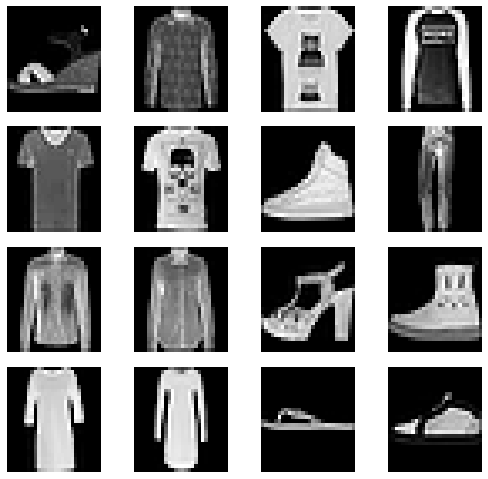

After


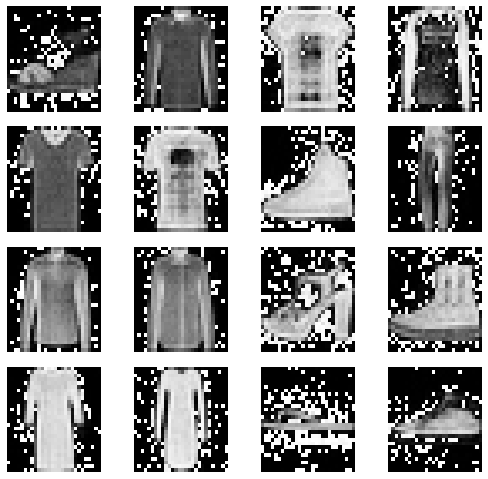

Loss: 0.0030769004952162504


In [31]:
with torch.no_grad():
  for data, _ in train_loader:

        img = data.cuda()
        output = model(img)
        loss = F.mse_loss(output, img)

        print('Before')
        show_images(img[:16])
        plt.show()
       
        print('After')
        show_images(output[:16])
        plt.show()

        print("Loss: " + str(loss.item()))
        break

#Test set (no Class 8)

Before


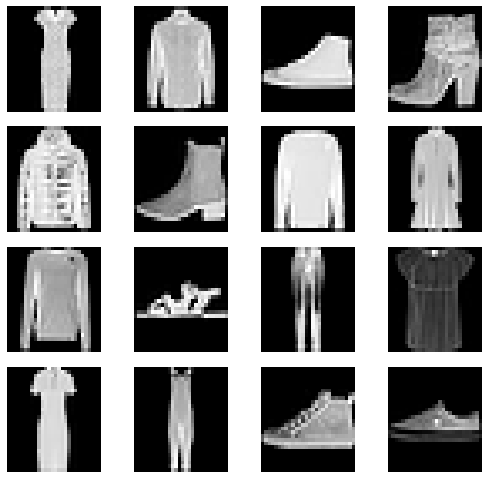

After


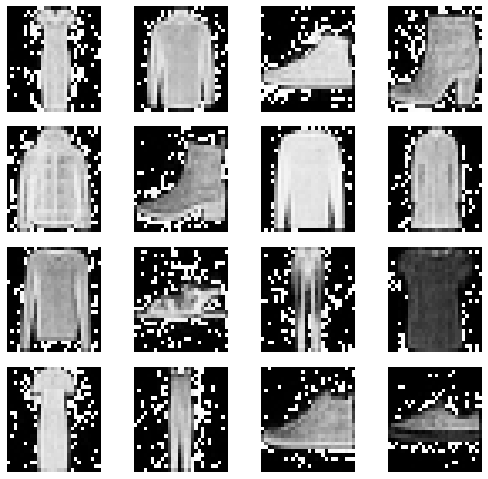

Loss: 0.002888964954763651


In [32]:
with torch.no_grad():
  for data, _ in test_no_class_8_loader:

        img = data.cuda()
        output = model(img)
        loss = F.mse_loss(output, img)

        print('Before')
        show_images(img)
        plt.show()
       
        print('After')
        show_images(output)
        plt.show()

        print("Loss: " + str(loss.item()))
        break

#Test set (Class 8)

Before


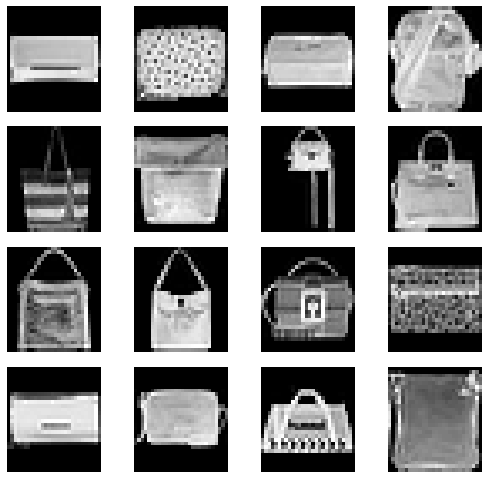

After


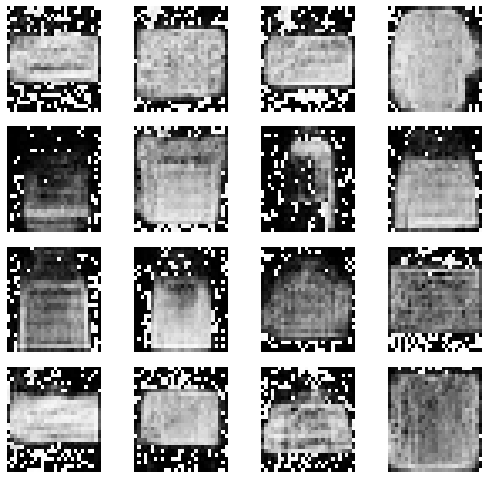

Loss: 0.020809268578886986


In [34]:
with torch.no_grad():
  for data, _ in test_class_8_loader:

        img = data.cuda()
        output = model(img)
        loss = F.mse_loss(output, img)

        print('Before')
        show_images(img)
        plt.show()
       
        print('After')
        show_images(output)
        plt.show()

        print("Loss: " + str(loss.item()))
        break